In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import registration, transform

In [3]:

def create_gaussian_image(shape=(256, 256), center=None, sigma=10):
    """
    Create a 2D Gaussian image.

    Parameters:
    - shape: tuple, the shape of the image (rows, cols)
    - center: tuple, the center of the Gaussian (y, x). If None, centered.
    - sigma: float, standard deviation of the Gaussian.

    Returns:
    - image: 2D numpy array with Gaussian.
    """
    if center is None:
        center = (shape[0] / 2, shape[1] / 2)
    Y, X = np.indices(shape)
    dist_sq = (X - center[1])**2 + (Y - center[0])**2
    image = np.exp(-dist_sq / (2 * sigma**2))
    return image

def shift_image(image, shift):
    """
    Shift the image by the given (y, x) shift using Fourier shift.

    Parameters:
    - image: 2D numpy array.
    - shift: tuple, (y_shift, x_shift).

    Returns:
    - shifted_image: 2D numpy array.
    """
    shifted_image = transform.warp(image, transform.AffineTransform(translation=shift), mode='wrap')
    return shifted_image


True shift: (5.5, -12.3)
Estimated shift: [-12.15   5.5 ]


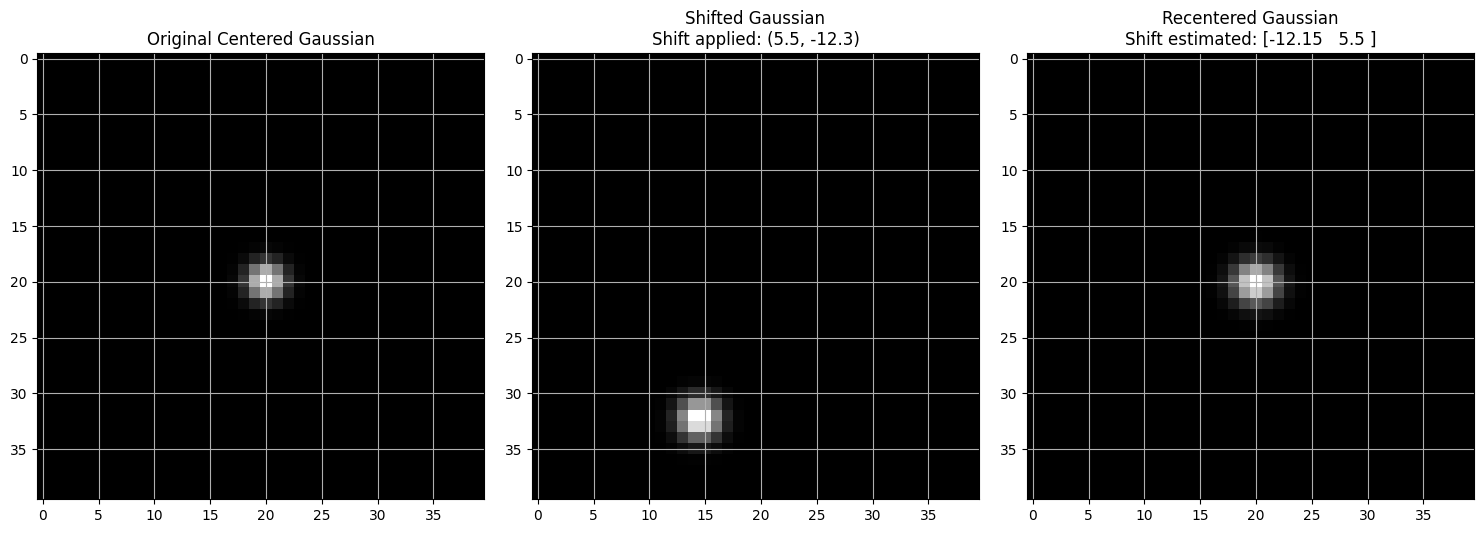

In [4]:

# Step 1: Create a centered Gaussian image
image_shape = (40, 40)
centered_gaussian = create_gaussian_image(shape=image_shape, sigma=1.127)

# Step 2: Shift the Gaussian image
true_shift = (5.5, -12.3)  # (y_shift, x_shift)
shifted_gaussian = shift_image(centered_gaussian, shift=true_shift)

# Step 3: Estimate the shift using phase_cross_correlation
# Note: phase_cross_correlation expects float images
estimated_shift, error, diffphase = registration.phase_cross_correlation(
    centered_gaussian, shifted_gaussian, upsample_factor=100
)

print(f"True shift: {true_shift}")
print(f"Estimated shift: {estimated_shift}")

# Step 4: Recenter the shifted image by applying the inverse of the estimated shift
# To recenter, we shift by (-estimated_shift)
recenter_transform = transform.AffineTransform(translation=(-estimated_shift[1], -estimated_shift[0]))
recentered_gaussian = transform.warp(shifted_gaussian, recenter_transform, mode='wrap')

# Step 5: Display the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax = axes.ravel()

ax[0].imshow(centered_gaussian, cmap='gray')
ax[0].set_title('Original Centered Gaussian')
ax[0].grid(True)
# ax[0].axis('off')

ax[1].imshow(shifted_gaussian, cmap='gray')
ax[1].set_title(f'Shifted Gaussian\nShift applied: {true_shift}')
# ax[1].axis('off')
ax[1].grid(True)

ax[2].imshow(recentered_gaussian, cmap='gray')
ax[2].set_title(f'Recentered Gaussian\nShift estimated: {estimated_shift}')
# ax[2].axis('off')
ax[2].grid(True)

plt.tight_layout()
plt.show()


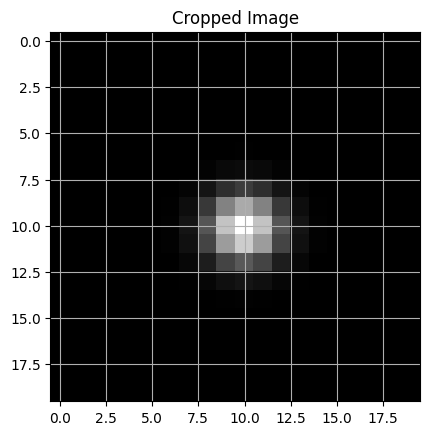

In [5]:
img_height, img_width = recentered_gaussian.shape
crop_height, crop_width = 20, 20

# Calculate the starting indices for the crop
start_y = (img_height - crop_height) // 2
start_x = (img_width - crop_width) // 2

# For odd dimensions, ensure correct indexing
# Since 101 is odd and 20 is even, this works correctly
end_y = start_y + crop_height
end_x = start_x + crop_width

# Crop the image
cropped_image = recentered_gaussian[start_y:end_y, start_x:end_x]

plt.imshow(cropped_image, cmap='gray')
plt.title('Cropped Image')
plt.grid(True)
plt.show()

In [6]:
from scipy.signal import convolve2d as conv2
from skimage import color, data, restoration, transform

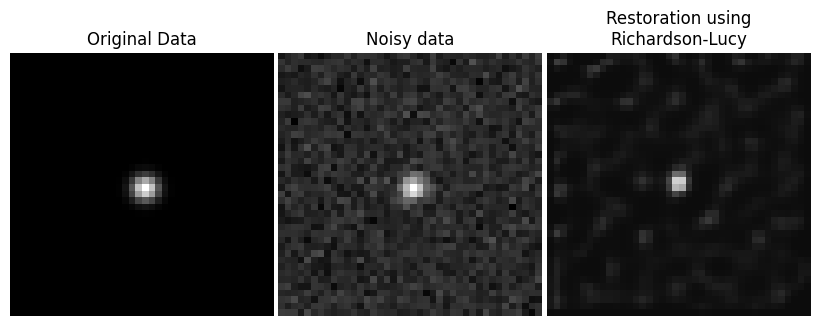

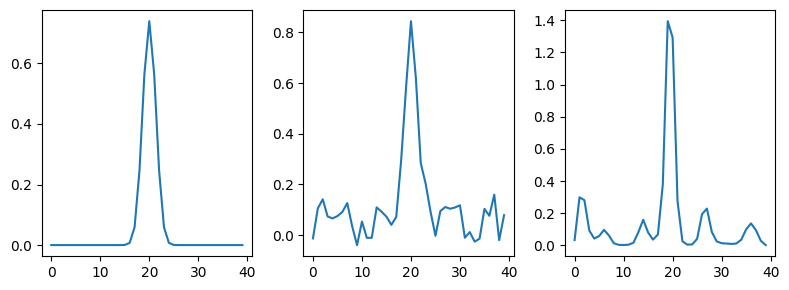

In [7]:

rng = np.random.default_rng()

# astro = color.rgb2gray(data.astronaut())

psf = cropped_image
astro = recentered_gaussian
# Add Noise to Image
astro_noisy = astro.copy()
noise = rng.normal(0.05, 0.05, astro.shape)
astro_noisy += noise # (rng.poisson(lam=25, size=astro.shape) - 10) / 255.0

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, num_iter=10, clip=False)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
    a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, 
            #  vmin=astro_noisy.min(), vmax=astro_noisy.max()
            vmin=-0.1, vmax=2.0
             )
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))
ax[0].plot(astro[20, :], label='Original')
ax[1].plot(astro_noisy[20, :], label='Noisy')
ax[2].plot(deconvolved_RL[20, :], label='Restored')
plt.tight_layout()
plt.show()

In [8]:
from astropy.visualization import simple_norm
import pandas as pd
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.nddata import Cutout2D

from photutils.detection import DAOStarFinder

/Users/alexeysergeyev/code/python/skymapper_gls/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 id     xcentroid          ycentroid      ...    mag         daofind_mag     
--- ------------------ ------------------ ... ---------- --------------------
  1 110.40118928859769 23.249998902483643 ...  -8.291465  -1.0470604970530206
  2  52.42674446490726  36.89713946352571 ...  -8.290777  -1.0106087235373709
  3 53.291176893622705 52.399416346444454 ...  -9.627187   -1.681253087178296
  4  59.51346675023431   52.3860967010954 ...  -9.897904  -0.9392173772619121
  5 20.242675384132923  52.94403861415674 ...  -9.064706  -1.8892796096124085
  6 36.338992280290704 55.879834385102576 ...  -9.673778  -2.3999926733825703
  7  56.86377851433704  55.92915212596027 ... -11.523697   -3.888804719420582
  8  59.30389053028678  75.76777502975229 ...  -8.073237  -1.2469557579874644
  9 63.331254402650764  77.64517740640142 ...  -8.103888  -1.2928369980396908
 10  66.80620299910792  79.65432794714982 ...  -8.445682  -1.7972243656088651
 11  73.93662660471861 109.39476135844752 ...   -7.30403 -0.1725

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


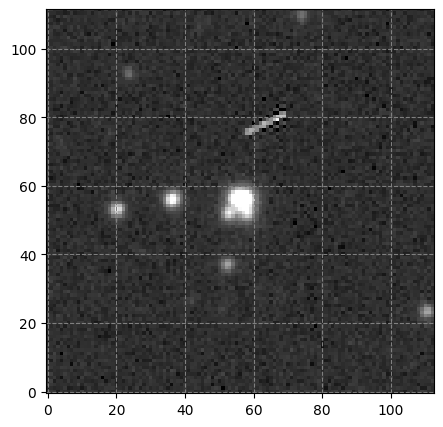

[4.245 3.694 3.051 4.527] [4.498 4.644 3.426 3.435]


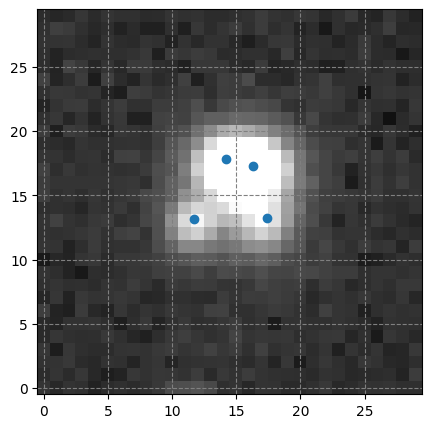

In [9]:
df_candidates = pd.read_csv('../data//candidates2.csv')
gr = df_candidates.groupby('source_id_smss')
source_id = 30885280
group = gr.get_group(source_id)
band = 'r'
hdul_r = fits.open("../data/30885280_r.fits")
w_r = WCS(hdul_r[0].header)
data_r = hdul_r[0].data
header_r = hdul_r[0].header
hdul_r.close()

mean, median, std = sigma_clipped_stats(data_r, sigma=3.0)  
daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)

data_r -= median
sources = daofind(data_r)
print(sources)
for col in sources.colnames:  
    sources[col].info.format = '%.4g'
#print(sources)
x_centroid = np.array(sources['xcentroid'])
y_centroid = np.array(sources['ycentroid'])

plt.figure(figsize=(5, 5))
norm = simple_norm(data_r, 'sqrt', percent=99.5)
plt.imshow(data_r, origin='lower', cmap='gray', norm=norm)
plt.grid(True, color='gray', linestyle='--')
coords = SkyCoord(ra=group.iloc[0]['ra_smss'], 
                  dec=group.iloc[0]['dec_smss'], 
                  unit=(u.deg, u.deg))
plt.show()
# %%

src = Cutout2D(data_r.data, (56, 54), size=(30, 30))
simulated_image = src.data

center_pixel_x = src.data.shape[0] / 2
center_pixel_y = src.data.shape[1] / 2
x_image = np.array([0.345,  -0.206,  -0.849, 0.627])
y_image = np.array([ 0.598, 0.744,  -0.474, -0.465])

background_rms = .5  # background noise per pixel
exp_time = 90  # exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 20  # cutout pixel size
deltaPix = 0.26  # pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.69  # full width half max of PSF


plt.figure(figsize=(5, 5))
norm = simple_norm(data_r, 'sqrt', percent=99.5)
plt.imshow(src.data, origin='lower', cmap='gray', norm=norm)
plt.grid(True, color='gray', linestyle='--')
x_pix = center_pixel_x + x_image / deltaPix
y_pix = center_pixel_y + y_image / deltaPix
x_angular = x_pix * deltaPix
y_angular = y_pix * deltaPix
print(x_angular, y_angular)

plt.scatter(x_pix, 
            y_pix)

plt.show()

In [10]:
fwhm = 0.69  # full width half max of PSF
scale = 0.26  # pixel scale
sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # conversion from FWHM to sigma
print(sigma / scale)


1.126984696536025


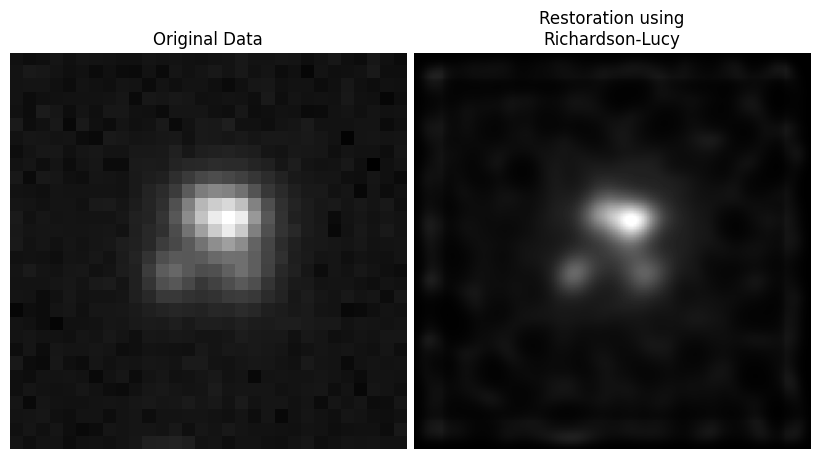

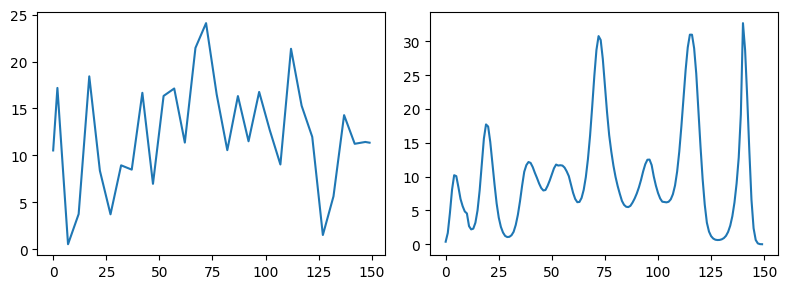

In [28]:
psf = cropped_image
astro = transform.rescale(src.data, 5.0) + 10
gauss = create_gaussian_image(
    shape=(cropped_image.shape[0], 
    cropped_image.shape[1]), sigma=5.0 * 1.127)
# psf = transform.rescale(gauss, 4.0)
psf = gauss.copy()
# Add Noise to Image
# astro_noisy = astro.copy()
# noise = rng.normal(0.05, 0.05, astro.shape)
# astro_noisy += noise # (rng.poisson(lam=25, size=astro.shape) - 10) / 255.0

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro, psf, num_iter=20, clip=False)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1]):
    a.axis('off')

norm = simple_norm(src.data, 'sqrt', percent=99.9)
ax[0].imshow(src.data, 
             norm=norm,
             origin='lower'
             )
ax[0].set_title('Original Data')

norm_dec = simple_norm(deconvolved_RL, 'sqrt', percent=99.9)
ax[1].imshow(deconvolved_RL, 
            #  vmin=astro.min(), vmax=astro.max()
            # vmin=-0.1, vmax=1
            norm=norm_dec,
            origin='lower'
             )

ax[1].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2, top=0.9, bottom=0.05, left=0, right=1)
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
ax[0].plot(astro[30, :], label='Original')
ax[1].plot(deconvolved_RL[30, :], label='Restored')
plt.tight_layout()
plt.show()

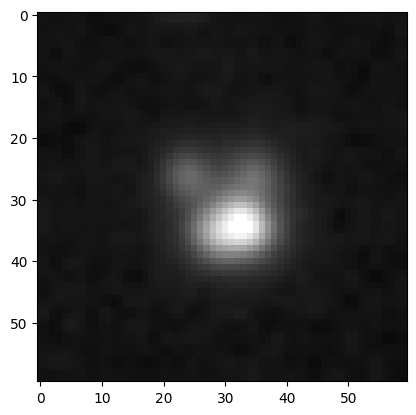

In [102]:
astro_scale = transform.rescale(astro, 2.0, anti_aliasing=False)
# norm = 
plt.imshow(astro_scale, cmap='gray',
            norm=norm
           )